In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mvlearn.embed import MCCA


from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_survival_prediction
from src.constants import RANDOM_STATE
from src.pipelines import classification_pipeline, regression_pipeline

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [2]:
survival_data_breast = pd.read_csv('data/breast/survival_data_breast.csv')
dna_breast = pd.read_csv('data/breast/expression_data_breast.csv', index_col=[0]).fillna(0.)
rna_breast = pd.read_csv('data/breast/mirna_data_breast.csv', index_col=[0]).fillna(0.)
methylation_breast = pd.read_csv('data/breast/methylation_data_breast.csv', index_col=[0]).fillna(0.)

mofa_data_breast = pd.read_csv('data/breast/mofa_data_breast.csv')
clinical_data_breast = pd.read_csv('data/breast/clinical_data_breast.csv')

assert (survival_data_breast['PatientID'] == mofa_data_breast['sample'].drop_duplicates()).all()
assert (clinical_data_breast['sampleID'] == mofa_data_breast['sample'].drop_duplicates()).all()

In [3]:
N_FACTORS = 20
TRAIN_INDICES, TEST_INDICES = split_patients_for_survival_prediction(survival_data_breast)

Из клинических данных вручную отобраны фичи, которые не связаны с таргетом, содержат более 80% непустых данных и более 1 уникального значения, и которые не являются техническими (названия файлов, идентификаторы и прочее)

In [4]:
CATEGORICAL_CLINICAL_FEATURES = ['anatomic_neoplasm_subdivision', 'axillary_lymph_node_stage_method_type',
                                 'breast_carcinoma_estrogen_receptor_status',
                                 'breast_carcinoma_progesterone_receptor_status',
                                 'breast_carcinoma_surgical_procedure_name',
                                 'gender',
                                 'histological_type',
                                 'history_of_neoadjuvant_treatment',
                                 'icd_10',
                                 'icd_o_3_histology',
                                 'icd_o_3_site',
                                 'initial_pathologic_diagnosis_method',
                                 'lab_proc_her2_neu_immunohistochemistry_receptor_status',
                                 'margin_status',
                                 'menopause_status',
                                 'new_tumor_event_after_initial_treatment',
                                 'oct_embedded',
                                 'pathologic_M',
                                 'pathologic_N',
                                 'pathologic_T',
                                 'pathologic_stage',
                                 'person_neoplasm_cancer_status',
                                 'primary_lymph_node_presentation_assessment',
                                 'radiation_therapy',
                                 'system_version',
                                 'tissue_prospective_collection_indicator',
                                 'tissue_retrospective_collection_indicator',
                                 'tissue_source_site']
NUMERICAL_CLINICAL_FEATURES = ['age_at_initial_pathologic_diagnosis',
                               'initial_weight', 'lymph_node_examined_count', 'number_of_lymphnodes_positive_by_he']
N_CATEGORICAL_CLINICAL = len(CATEGORICAL_CLINICAL_FEATURES)
N_NUMERIC_CLINICAL = len(NUMERICAL_CLINICAL_FEATURES)

In [5]:
clinical_features = clinical_data_breast[NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

for col in CATEGORICAL_CLINICAL_FEATURES:
    clinical_features[col] = clinical_features[col].fillna('missing')

clinical_features.head()

,age_at_initial_pathologic_diagnosis,initial_weight,lymph_node_examined_count,number_of_lymphnodes_positive_by_he,anatomic_neoplasm_subdivision,axillary_lymph_node_stage_method_type,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,breast_carcinoma_surgical_procedure_name,gender,...,pathologic_N,pathologic_T,pathologic_stage,person_neoplasm_cancer_status,primary_lymph_node_presentation_assessment,radiation_therapy,system_version,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site
0,55.0,60.0,13.0,4.0,Left Lower Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,NX,TX,Stage X,WITH TUMOR,YES,NO,6th,NO,YES,3C
1,50.0,120.0,15.0,1.0,Right Upper Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Lumpectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,YES,6th,NO,YES,3C
2,62.0,NaN,23.0,1.0,Right,missing,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,NO,7th,NO,YES,3C
3,52.0,140.0,2.0,0.0,Right,Sentinel node biopsy alone,Positive,Positive,Simple Mastectomy,FEMALE,...,N0 (i+),T1c,Stage IA,TUMOR FREE,YES,NO,7th,NO,YES,3C
4,50.0,770.0,14.0,4.0,Left|Left Upper Outer Quadrant,Axillary lymph node dissection alone,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N2a,T2,Stage IIIA,TUMOR FREE,YES,NO,7th,YES,NO,4H


### Обучаем модели факторизации

MOFA

In [6]:
mofa_factors, weights, r2 = train_mofa(mofa_data_breast.copy(), RANDOM_STATE, factors=N_FACTORS)
clear_output()

MCCA

In [7]:
cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_factors = cca.fit_transform([dna_breast.values, rna_breast.values, methylation_breast.values])

PCA

In [8]:
X_breast_all = np.hstack([dna_breast.values, rna_breast.values, methylation_breast.values])

In [9]:
pca = PCA(n_components=N_FACTORS)
pca_factors = pca.fit_transform(X_breast_all)

## Классификация: предсказание смерти

In [10]:
pipeline_base_args = [clinical_features, survival_data_breast, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE,
                       X_breast_all.shape[1], N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

pipeline_args = [clinical_features, survival_data_breast, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE,
                       N_FACTORS, N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

### Бейзлайн: без факторизации

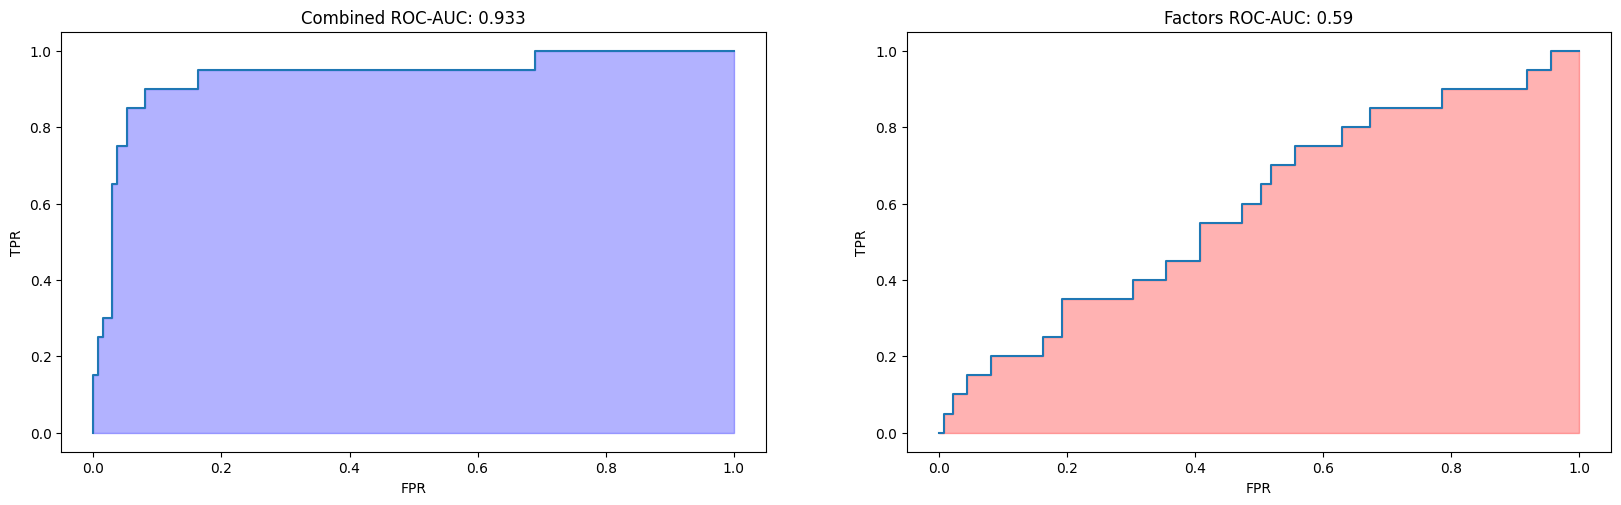

In [11]:
r_f_base, r_c_base = classification_pipeline(X_breast_all, *pipeline_base_args, plot_feat_imp=False)

### MOFA

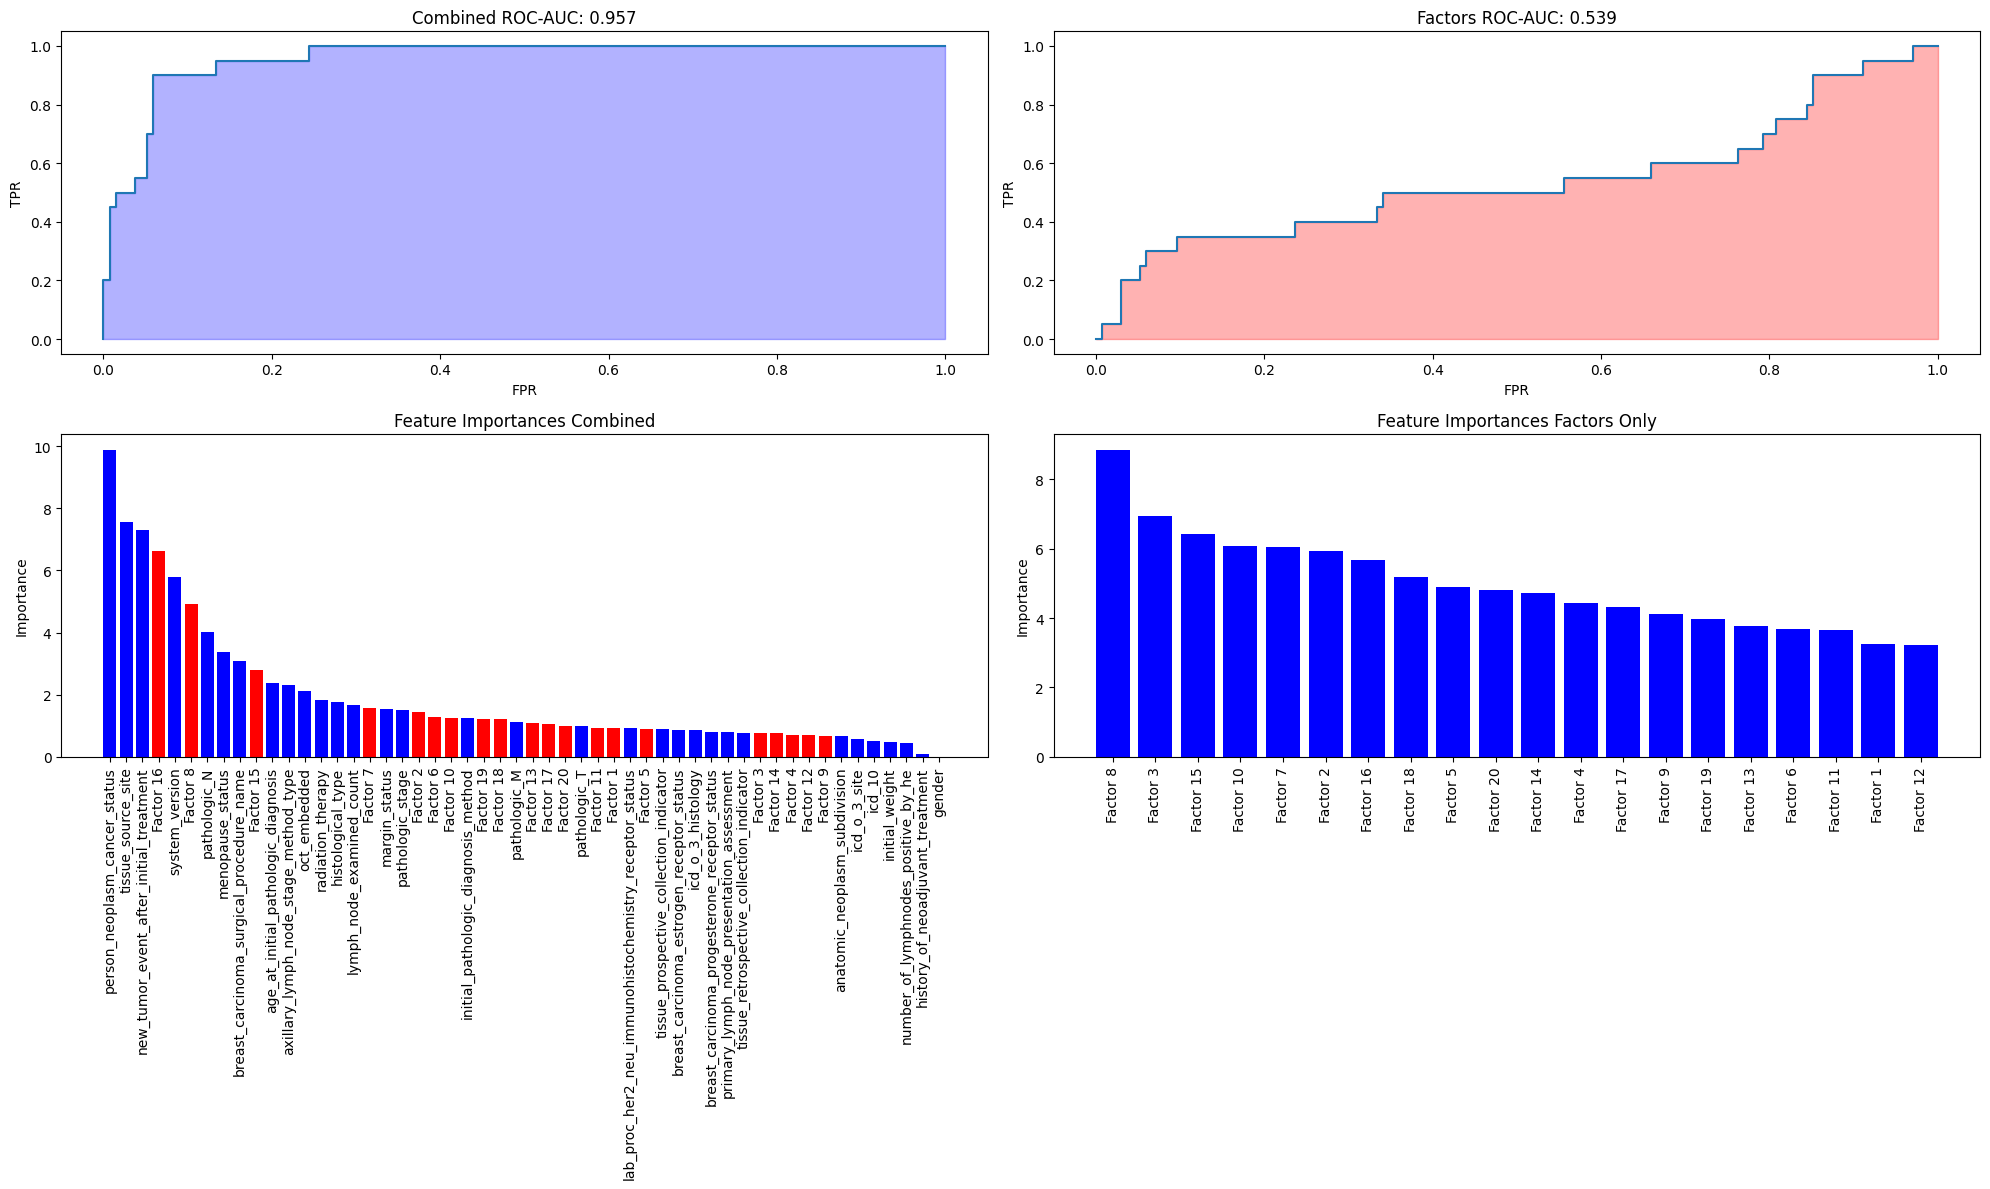

In [12]:
r_f_mofa, r_c_mofa, f_f_mofa, f_c_mofa = classification_pipeline(mofa_factors, *pipeline_args)

### MCCA

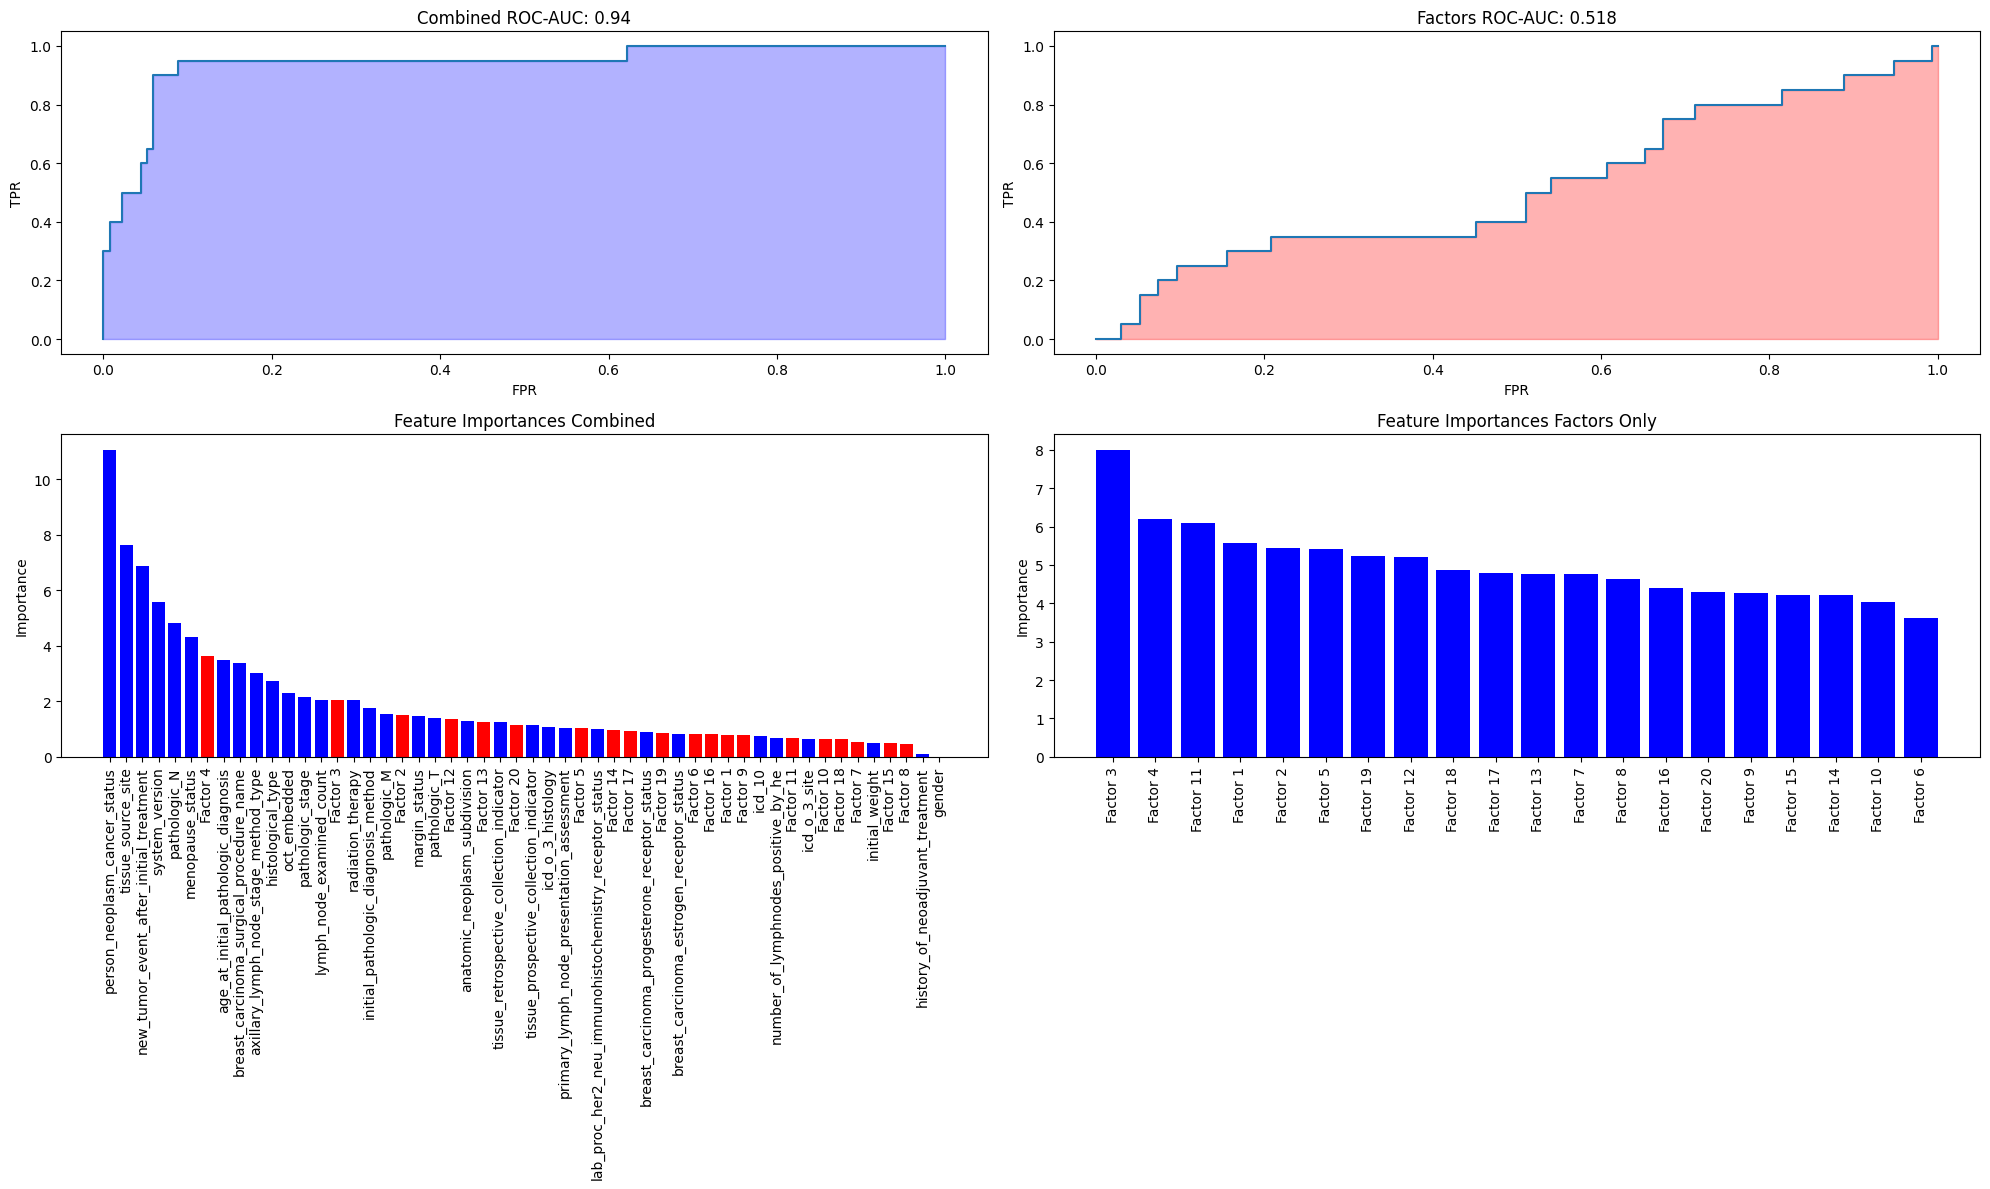

In [13]:
r_f_mcca, r_c_mcca, f_f_mcca, f_c_mcca = classification_pipeline(mcca_factors, *pipeline_args)

### PCA

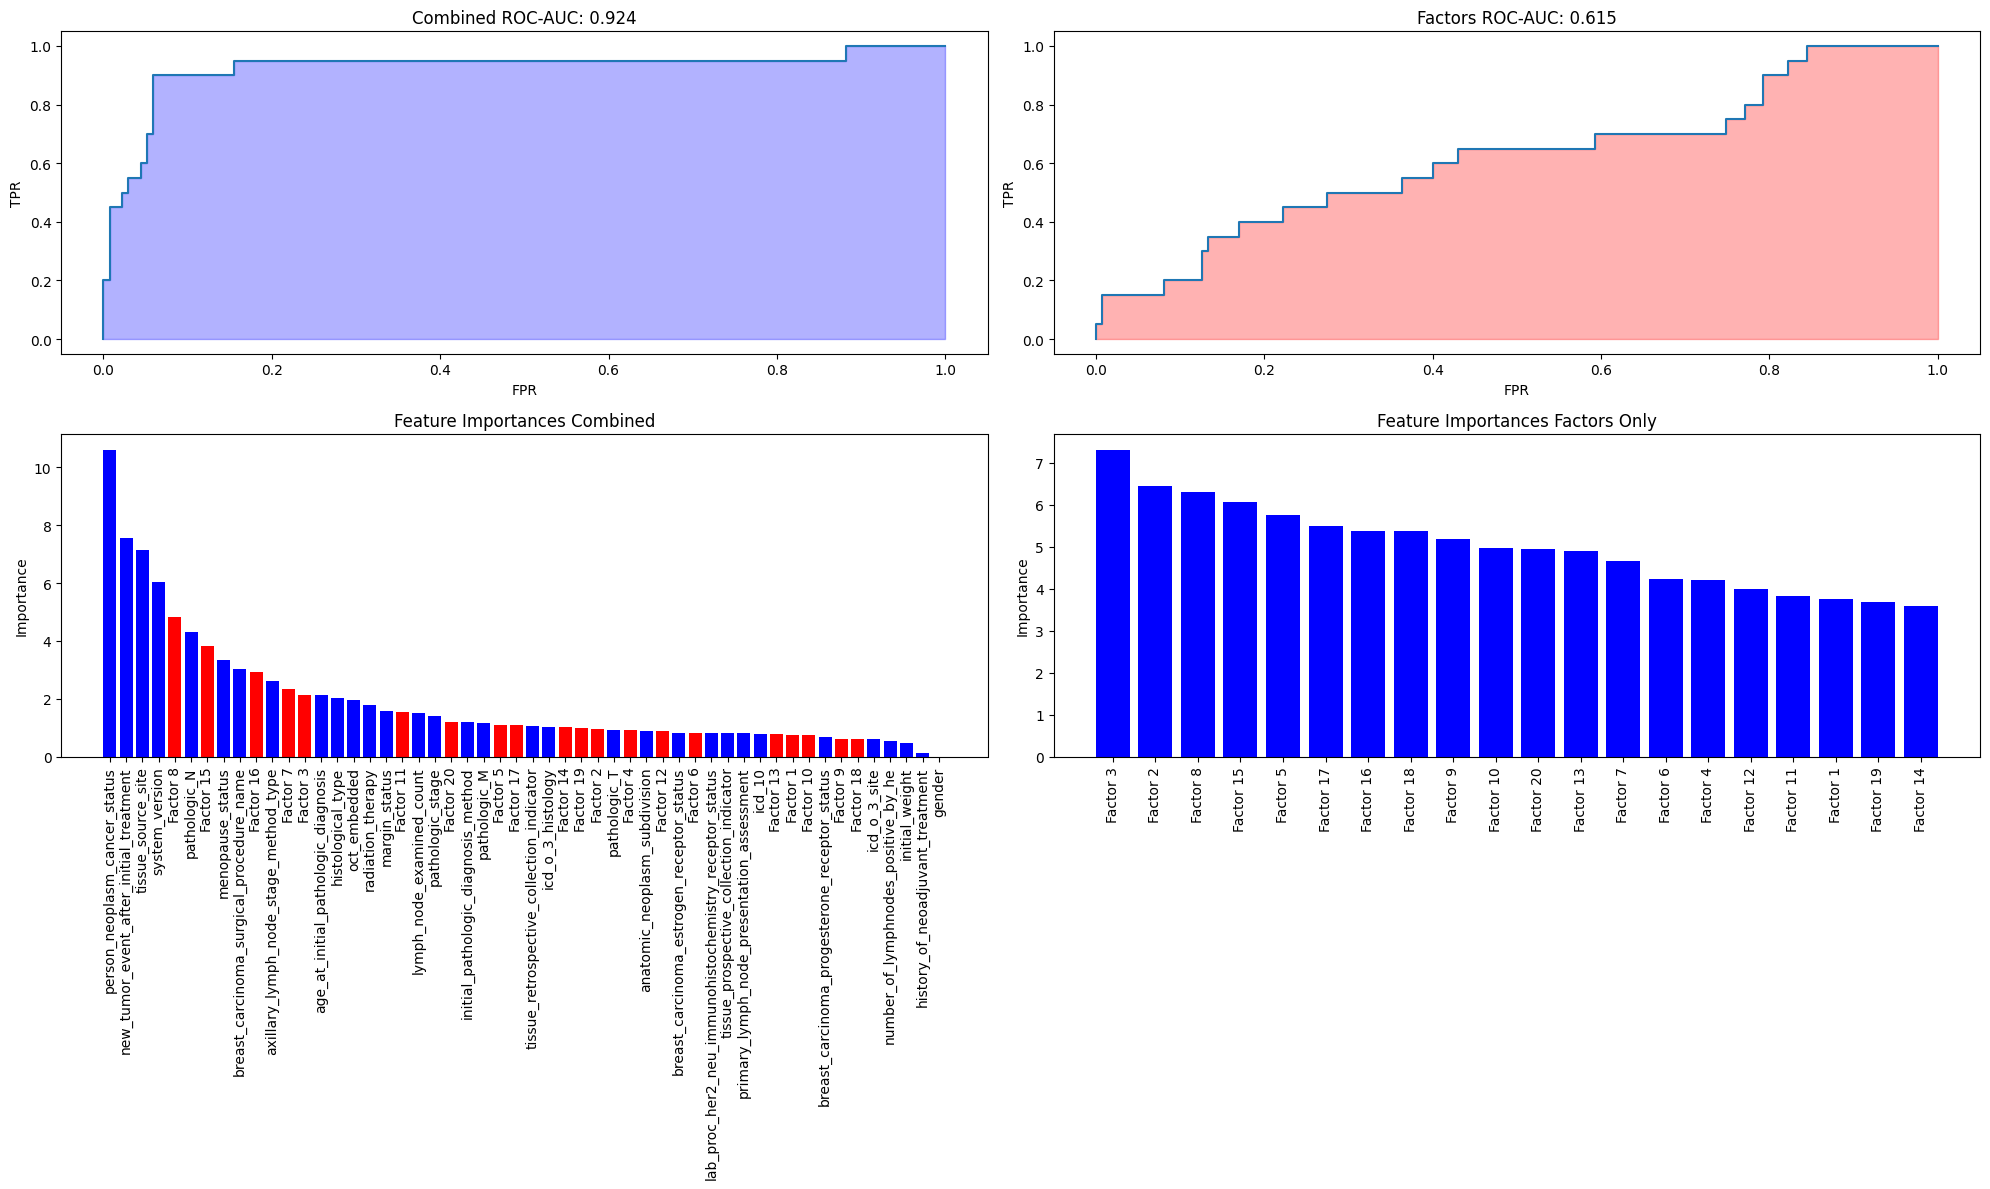

In [14]:
r_f_pca, r_c_pca, f_f_pca, f_c_pca = classification_pipeline(pca_factors, *pipeline_args)

### Классификация, результаты:

In [15]:
class_results = pd.DataFrame({
    'ROC-AUC factors': [r_f_base, r_f_mofa, r_f_mcca, r_f_pca],
    'ROC-AUC factors + clinical': [r_c_base, r_c_mofa, r_c_mcca, r_c_pca],
}, index=['No factorization', 'MOFA', 'MCCA', 'PCA'])

class_results

,ROC-AUC factors,ROC-AUC factors + clinical
No factorization,0.590370,0.932593
MOFA,0.538889,0.957037
MCCA,0.517778,0.939630
PCA,0.614815,0.924444


## Регрессия: предсказание survival

### Бейзлайн: без факторизации

In [16]:
m_f_base, m_c_base = regression_pipeline(X_breast_all, *pipeline_base_args, plot_feat_imp=False)

### MOFA

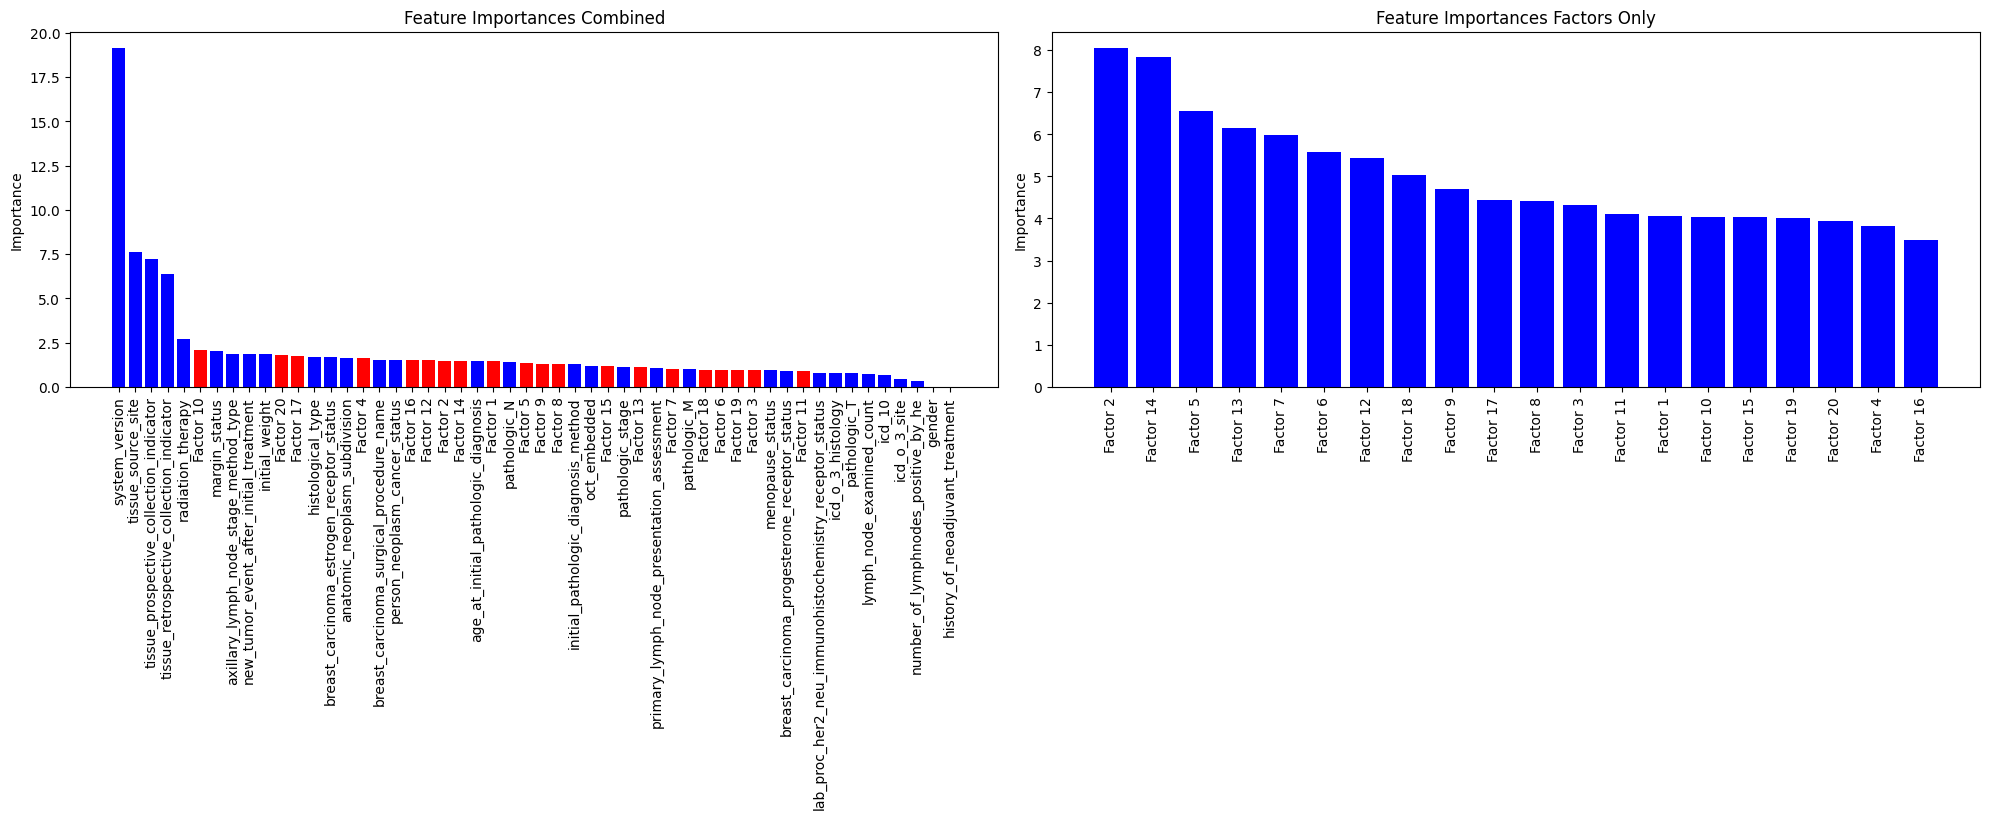

In [18]:
m_f_mofa, m_c_mofa, _, _ = regression_pipeline(mofa_factors, *pipeline_args)

### MCCA

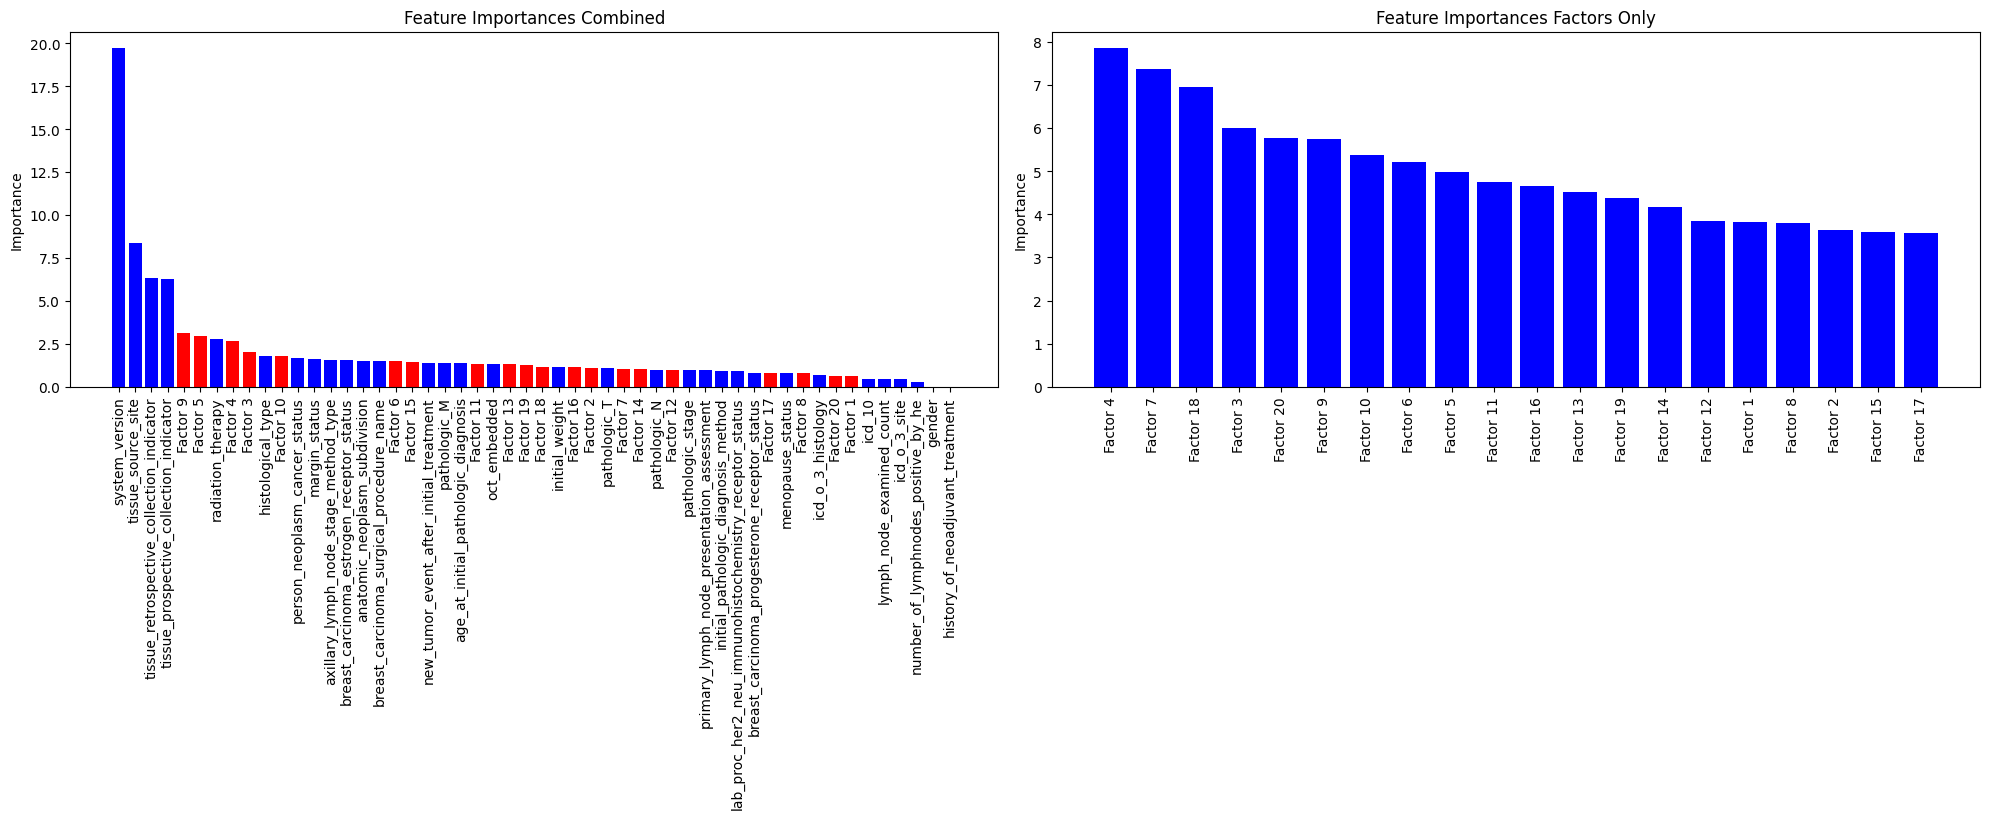

In [19]:
m_f_mcca, m_c_mcca, _, _ = regression_pipeline(mcca_factors, *pipeline_args)

### PCA

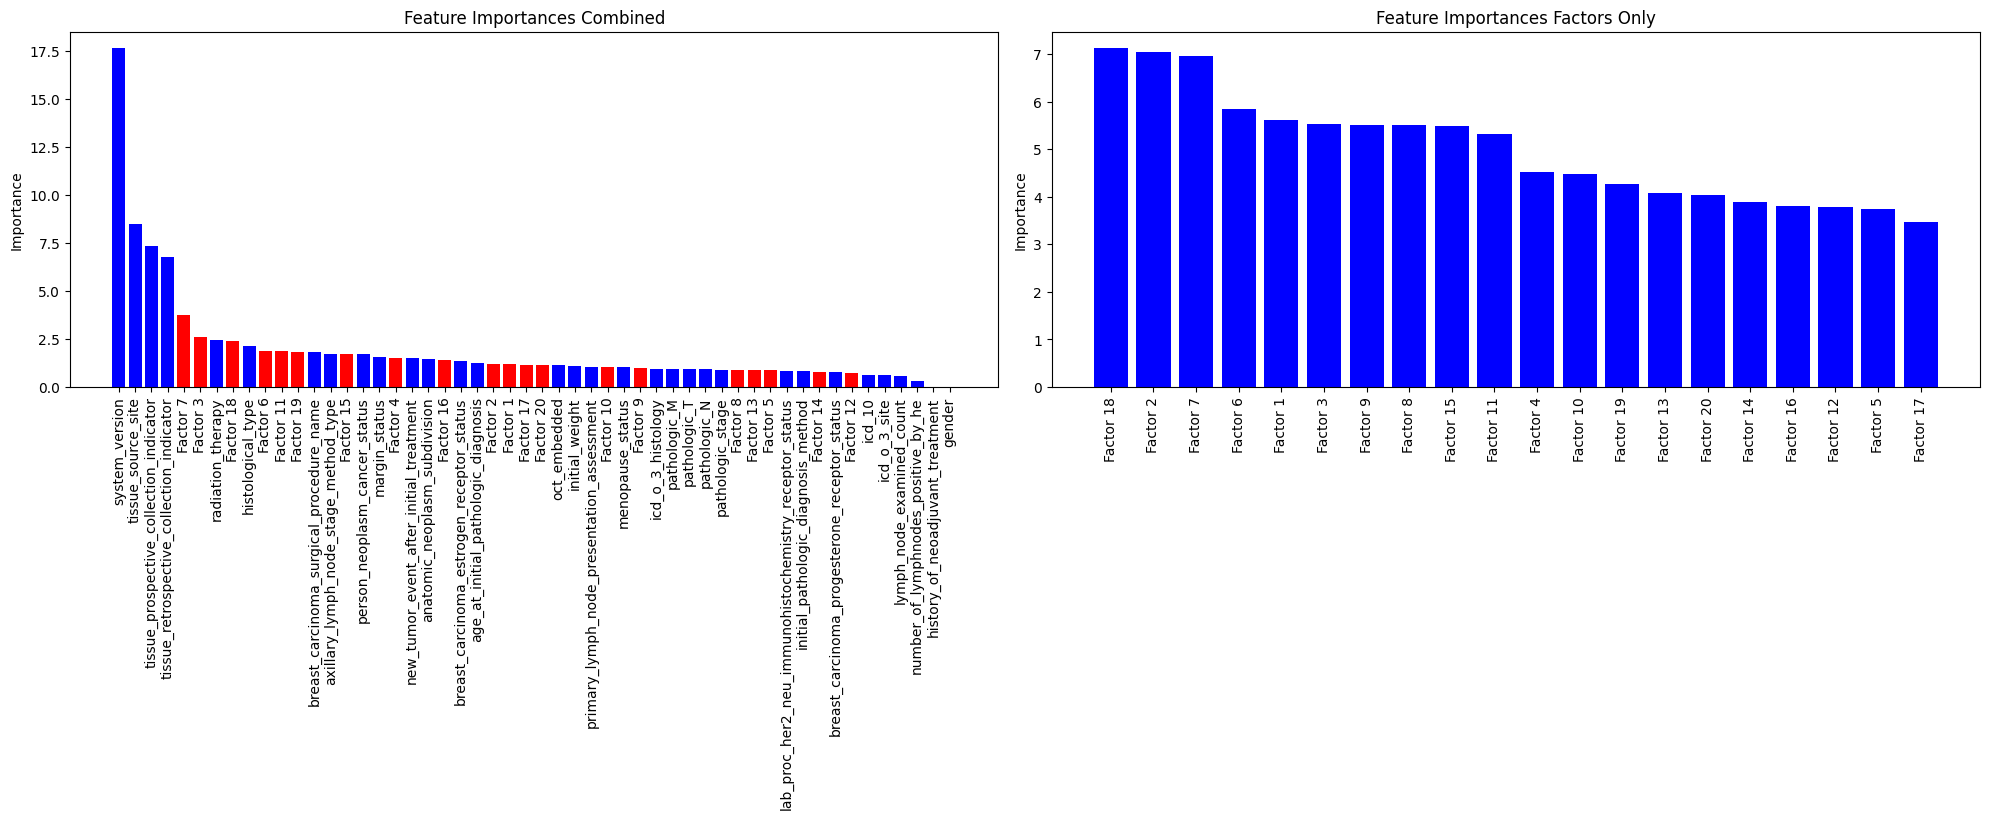

In [20]:
m_f_pca, m_c_pca, _, _ = regression_pipeline(pca_factors, *pipeline_args)

### Регрессия, результаты:

In [21]:
regr_results = pd.DataFrame({
    'MAPE factors, %': [m_f_base, m_f_mofa, m_f_mcca, m_f_pca],
    'MAPE factors + clinical, %': [m_c_base, m_c_mofa, m_c_mcca, m_c_pca],
}, index=['No factorization', 'MOFA', 'MCCA', 'PCA'])

regr_results

,"MAPE factors, %","MAPE factors + clinical, %"
No factorization,118.426546,91.729763
MOFA,141.167288,89.573776
MCCA,123.851514,88.329936
PCA,130.688693,87.622001
